<a href="https://colab.research.google.com/github/datrz/its.damian/blob/main/CNN_on_Pneumonia_Xrays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In light of the recent COVID-19 pandemic, I needed to prepare for the Deep Learning course a CNN model, that will help in having a closer look on one of the severe symptoms of the disease,  pneumonia.  The dataset I had consists of x-ray images of patients who either has pneumonia or are healthy, and I had to develop a model to distinguish them.

In [ ]:
## Import relevant packages

In [ ]:
#%% Imports
import os, os.path, shutil
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import splitfolders

#%% Random seed
seed = 2137
np.random.seed(seed)
tf.random.set_seed(seed)


## TASK 1: Preparation of the dataset

In [ ]:
# =============================================================================
# Splitting into folders
# =============================================================================

#Variable for where the data is located in our local harddrive
folder_path = '/Users/dtrzc/Library/CloudStorage/OneDrive-Personal/0_MASTERS/3_Deep_Learning/exam/data'

#creating a variable "images" where I go through the images in the whole folder
images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

#images.pop(415)
''' 
Sometimes there was a "dsstore" file (specfically for Mac computers)
For this reason I use this pop function to remove it. It is not necessary for windows
I have "muted" the line below.
'''

#I remove the einstein in our dataset and a corresponding pneumonia so make the dataset balanced.
images.remove('385_normal.jpg')
images.remove('385_pneumonia.jpg')

#Sanity check for number of images loaded
print(len(images))

''' 
For loop that splits the image file name into three parts and the split happens at "_" and "." 
all the file names looks like: "number"_"classname".img - I aminterested in "classname"
which is in the middle and turning this name into a new folder
'''

for image in images:
  folder_name = image.split("_")[1].split(".")[0]
#Join folder_name by adding it into our source folder where I have our data
  new_path = os.path.join(folder_path, folder_name)
#First time this folder would not exist so I will create it, which is only necessary the first iteration
  if not os.path.exists(new_path):
    os.makedirs(new_path)
    
#Now I can also take this specific image and ensure that the image will be put in the new folder
  old_image_path = os.path.join(folder_path, image)
  new_image_path = os.path.join(new_path, image)
  shutil.move(old_image_path, new_image_path)

#This function allows us to add a ratio into how I will separate the dataset. Seed is for randomizing
splitfolders.ratio(folder_path,
          output = folder_path,
          seed = 1337,
          ratio = (0.8, 0.15, 0.05))



Selected 80% of data for training, 15% for validation and 5% for testing. A common practice of DS is to 
do 80/20 split when doing train/test split. In our case I needed to reserve data for validation inbetween.
I wanted to feed the models with as much data as possible, at the same time having sufficient data for validating
the results

## TASK 2: Create the DataGenerators


Data augmentation, specifically image augmentation in our case, is a technique I can use to prevent
overfitting. This is done by expanding the size of the training dataset by making transformed version 
of the images in the dataset. These transformations or modification I can somewhat control with the
parameters in the function. I will be using the ImageDataGenerator from keras. 
This will only be applied to the training dataset as I am not interested in transforming the 
validation set and test set as the model needs to predict on unmodified data.


The model run fasted with smaller batch sizes and will update the gradient more often while 
trying to estimate the function.

I tested models with img size 250x250 and 500x500. The second gave us better performing models as normalized images
were more detailed. However, smaller dimensions speeded up fitting the model 3x

In [ ]:

# =============================================================================
# Image data generator
# =============================================================================

#the number of samples to work through before updating the internal model parameters. I set batch 
#size to 16 as our model takes a long time to train, so for this reason I keep it relatively low. 
batch_size = 16 

#The dimension of the images I am going to define is 500x500 which is one of our hyperparameters
img_height = 500
img_width = 500

"""
data augmentation techniques used for a training dataset must be chosen carefully and within 
the context of the training dataset and knowledge of the problem domain. For this reason, I keep
the augmentation fairly simple, as I am dealing with human physiology, and I am generally not
symmetrical creatures, so mirroring images would not be beneficial as I want to keep left side
of the body on the left. I do a few augmentations such as zoom, rotation, width and height shift
but I keep the effects low to ensure that it does not look too far apart from realistic images
"""

# Create Image Data Generator for our training set. I focus primarily on zoom, rotation, and shear
#range besides the normalization (rescaling)
image_gen = ImageDataGenerator(
                                rescale = 1./255,
                                rotation_range=10, 
                                zoom_range = 0.1, 
                                shear_range = 0.1       
                               )
#As mentioned earlier, I am not interested in augmenting the test and validation set 
#I am only interested in using the rescale parameter to ensure normalization on the two sets.
test_data_gen = ImageDataGenerator(rescale = 1./255)

#This function takes the path to a directory, and generates batches of augmented/normalized data. 
train = image_gen.flow_from_directory(
      os.path.join(folder_path, 'train'), #I want to specify this folder to use
      target_size=(img_height, img_width), #I have already defined these hyperparameters
      color_mode='grayscale', #set to grayscale which ensures 1 dimension for the colour which worked better than 3 dimensions
      class_mode='binary', #as I only are working with 2 classes
      batch_size=batch_size #I have also defined this hyperparameter earlier
      )

#The same parameters and definitions are used below.
test = test_data_gen.flow_from_directory(
      os.path.join(folder_path, 'test'),
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, # so I can later compare it with predicted values without having indexing problem
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      os.path.join(folder_path, 'val'),
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )


# =============================================================================
# Data Augmentation
# =============================================================================

''' , 
Visualizing examples of normalized data, both for Normal and Pneumonia cases from the training data set
'''

#Here I ensure to plot 10 random pictures of our dataset to look at them and their augmentations
#before I start training the model on the data. 
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'normal', 1:'pneumonia'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.savefig('fig1_normalized_training_samples.png')
plt.show()


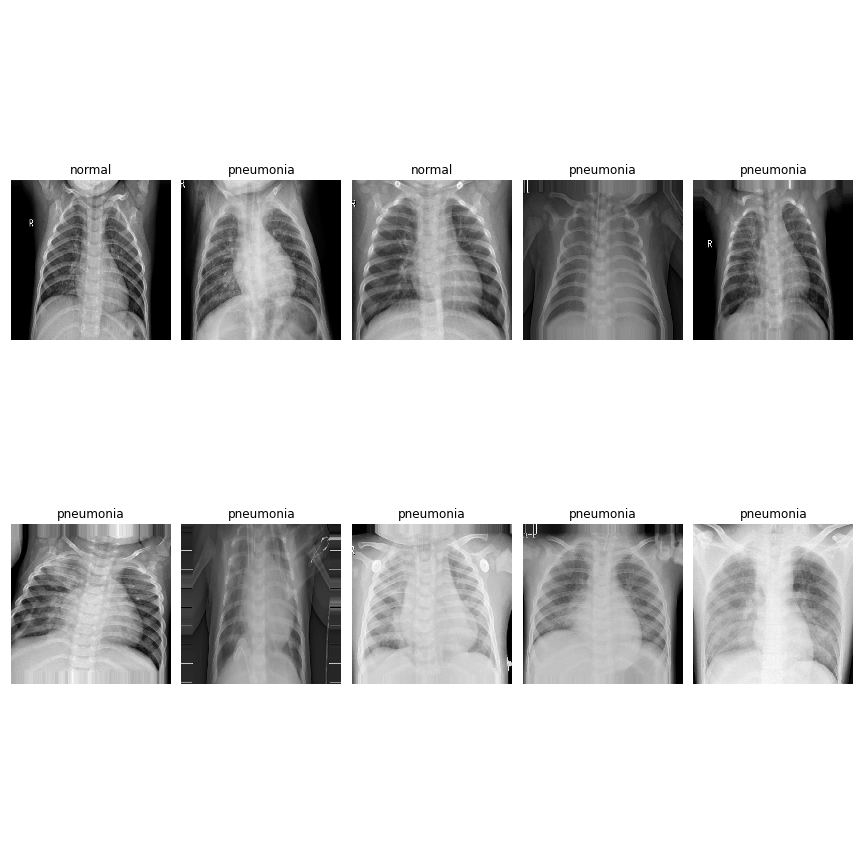

## TASK 3: Building the model

In order to best detect the patterns in the X-Ray images I chose to construct a Convolutional Neural Network.

I added Pooling layers to each Convolutional layer to be able to down-sample the input representation (image),
moreover, to decrease its dimensionality by retaining the maximum value (activated features) in the sub regions binding.

-  tuned the filter value and he found out that 32 and later on 64 gave us the most promising results.

- As mentioned above, I decided to design the model with a layer of Conv2D followed by a layer of MaxPooling.

-  tuned the kernel_size to be 3 x 3 for every layer. He also experimented with adding Dropout layers 
without major improvement in the model.

-  tested various activation functions such as tanh, relu and leaky relu, but eventually decided to use relu.
The Rectified Linear activation function (ReLU) is a piecewise linear function that outputs the input directly 
if it is positive, and zero otherwise. It overcomes the problem of vanishing gradients, allowing models to learn 
faster and perform better.

- I decided to flatten the input after the CNN layers and add 3 ANN layers, afterwards I tuned its 
hyperparamaters together.

- The sigmoid activation function for the last layer was a straight-forward choice for all of us, 
since it is a binary classification problem. Setting the units = 1 was another obvious decision.

- When compiling the model, it was again rather straight-forward to set the learning rate to "Adam", 
the loss function to "binary crossentropy", as well as the metrics to "accuracy".
Adam is an adaptive learning rate method, meaning that it computes individual learning rates for different parameters.
Since the nature of this problem is still binary classification, I used binary crossentropy for 
the evaluation of losses.
Setting the metrics to "accuracy" measured the loss and accuracy of both the training and validation sets.

In [ ]:
# =============================================================================
# Model
# =============================================================================

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(activation = 'sigmoid', units = 1))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()


### Visualizing the model's structure

The input shape of the images were (500, 500, 1) as I defined the height & width in the beginning.
The 1 represents the color channel.
Since the images are grayscale, the color channel is 1. For colorful images it would be 3 as per RGB.

As for (None, 500, 500, 1), Keras added an extra dimension called "None" as batch size may vary.

In the first Conv2d layer, the convolution operation on the image with size (500, 500) with a kernel size of (3, 3), with both strides and dilation set to 1, and padding set to "valid" by default, it spits out the output size of (500-3+1, 500-3+1) = (498, 498).
The number of filters I defined were 32, thus the output shape became (None, 498, 498, 32).

In the first MaxPooling2D layer, I defined the kernel size as (2, 2) and strides are by default (2, 2) as well.
Applying that to the input of image size of (498, 498) I get (((498–2)/2)+1,((498–2)/2)+1) = (249, 249)

At the Flatten layer toke all the pixels in all channels and created a 1D vector without taking the batchsize into consideration.
The input of (13, 13, 64) is therefore flattened to (13*13*64) = 10816 values.

In [ ]:
# =============================================================================
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)
plt.show()

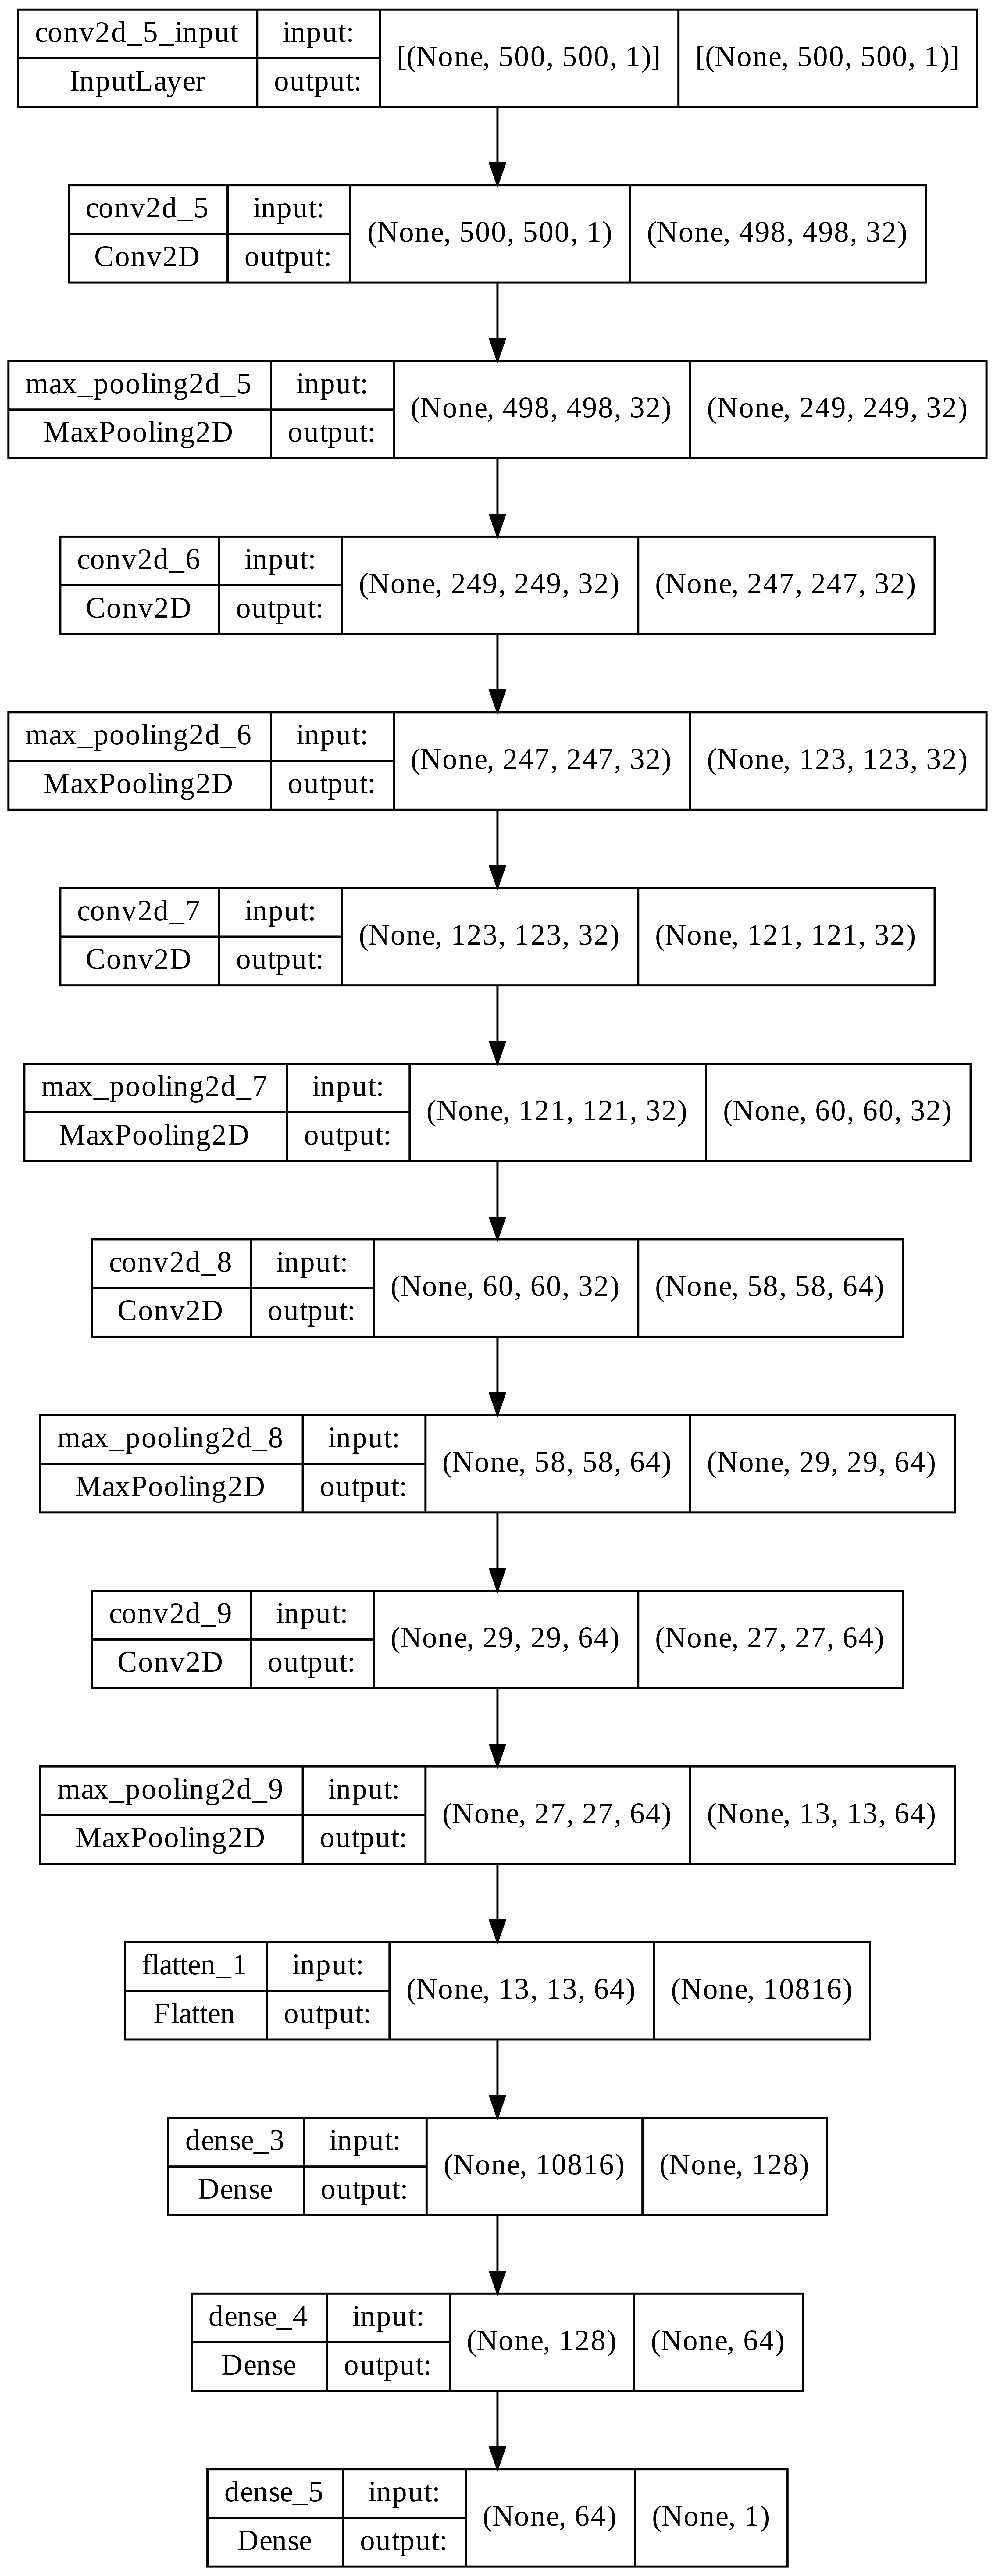

### Callbacks

I implemented the EarlyStopping function to stop the epochs based on some metric(monitor) and conditions(mode, patience).
In general it helps to reduce overfitting the model, by telling it to stop training based on the validated loss metric, that needs to be minimized.
Patience means that when a minimum "val_loss" is achieved, after that in the next iterations if the "val_loss" increases in any of the 3 iterations, 
then the training should stop at that epoch.

During fitting process, I run the model for 25 epochs with early stopping. The model was stopping after 18 epochs
Therefore I changed the code below so its runs for 18 epochs

I implemented the ReduceLROnPlateau function to reeduce the learning rate when a metric stopped improving.
Models often benefit from reducing the learning rate by a factor of 2–10 once the learning stagnates.
This callback monitors the quantity and if no improvement is seen for a "patience" number of epochs, the learning rate is reduced.

I implemented the ModelCheckpoint function to make sure that our best model gets saved on an ongoing basis during the training.
The save_best_only=True argument overwrites the previously saved model, thus ensures that I am left with the absolute best model at the very end.

In [ ]:
# =============================================================================
#early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
checkpoint = ModelCheckpoint(filepath='group_11_validated_model.h5', save_best_only=True)
#callbacks_list = [early, learning_rate_reduction, checkpoint]
callbacks_list = [learning_rate_reduction, checkpoint]

#%% Training the model
# =============================================================================
# fit
# =============================================================================
hist = model.fit(train,epochs=18, validation_data=valid, callbacks=callbacks_list)

### Plotting summary of the model

Plotting the models history allows us to evaluate performance of the model in each epoch. It contains loss function
values for train and validation tests, accuracy for train and validation sets and development of the learning rate

As the trainig nad validation accuracy improved in almost every epoch, I am confident that the model
has a potential to built  goog predictions


In [ ]:
hist_df = pd.DataFrame(hist.history)
plt.figure(figsize=(12, 12))
for i in [0,1]:
    colors = ['g','r','b','c','m']
    plt.subplot(2, 1, i+1)
    hist_df.iloc[:,i].plot(color=colors[i])
    plt.legend()
    hist_df.iloc[:,i+2].plot(color=colors[i+2])
    plt.title(hist_df.columns[i])
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
hist_df.iloc[:,4].plot(color=colors[4])
plt.title(hist_df.columns[4])
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# Test accuracy evaluation
# =============================================================================
'''   
Evaluation of the model by making a prediction on the test data set gives us an argument, that the model
seems to be good at generalizing and making good prediction, as the train set accuracy is 95,53%
which is close to the validation accuracy of 98,17%
'''

test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')


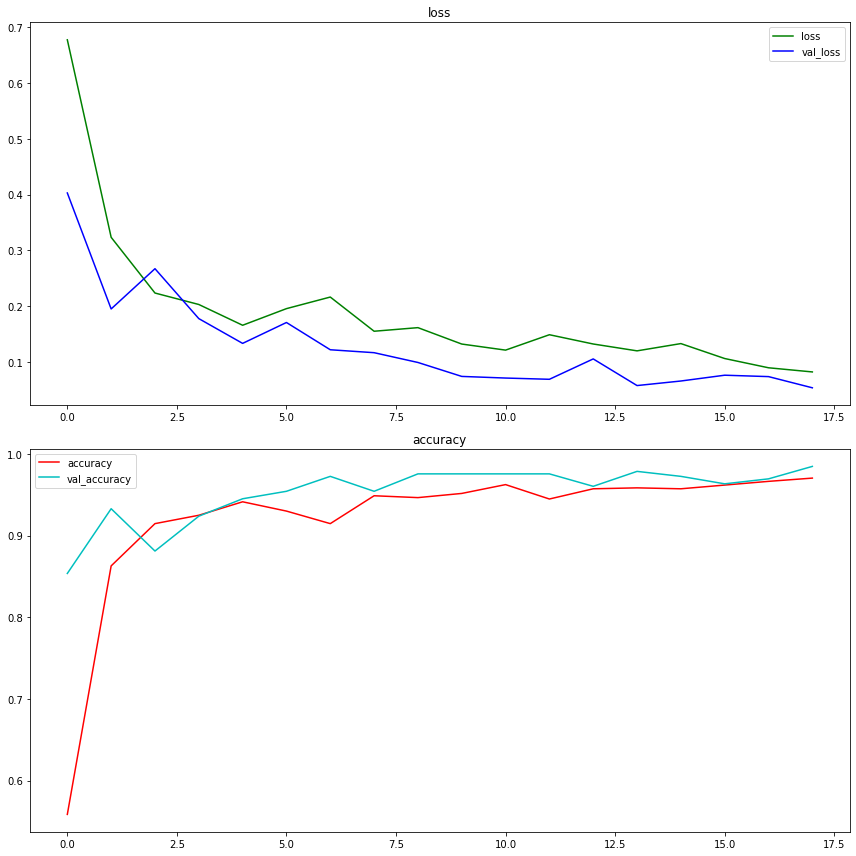

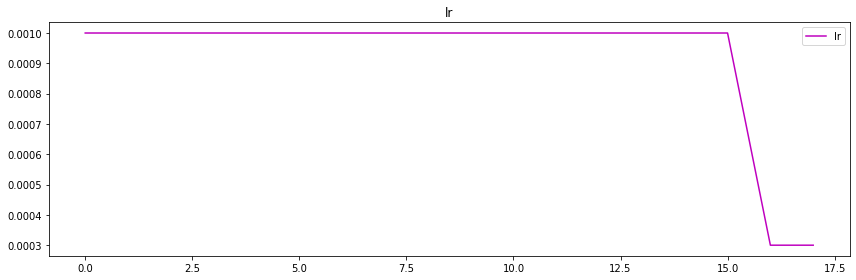

### Making predictions on the test set
 
I am making predictions on the test data set, using another function model.predict. It returns probabilities
that the obervation in a test dataset is normal or not normal. If its above thereshold defined by us on 0,5,
the model predicts pneumonia, if its below 0,5, the model predicts normal condition

Especially in health sector, thereshold 0,5 could be too low, when it comes to handling serious dieseases.
In certain cases one would like to be as certain as possible, that the model clasifies as patient as 
healthy / sick.

In [ ]:
preds = model.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

## TASK 4 Visualization

I am building a confusion matrix, which is a contigency table, showing us True Positives, True Negatives, 
False Positives and False Negatives predictions. On the diagonal axis with negative slope I observe the values
expected - True Positives and True Negatives. On the oposite diagonal I observe the misclassifications

The better performing the model, the less misclassifications it will have, based on the thereshold defined 
in the previous step


In [ ]:
# =============================================================================
# Confusion matrix for predictions
# =============================================================================

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])

sns.heatmap(cm,annot=True,fmt="d")
#%% Plotting examples of prediction
test.reset()

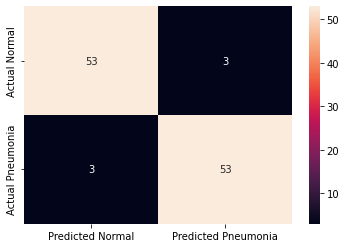

### Visualizing the predictions

In this step I am building a visualization of 9 predictions of the model and the confidence, expressed in %
on how confident the model is in predicting classes Normal / Pneumonia. The example shows that the model
gives us a good accuracy preformance on the test data and the misclassified image as Normal looks similar 
to the images of XRays from normal condions.  

In [ ]:

x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])

#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
visualize_index = 55
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0,9):
  plt.subplot(3, 3, i+1)
  if preds[i+visualize_index, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i+visualize_index][0]))    
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i+visualize_index][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i+visualize_index]))    
  plt.imshow(np.squeeze(x[i+visualize_index]))
plt.axis('off')
plt.show()

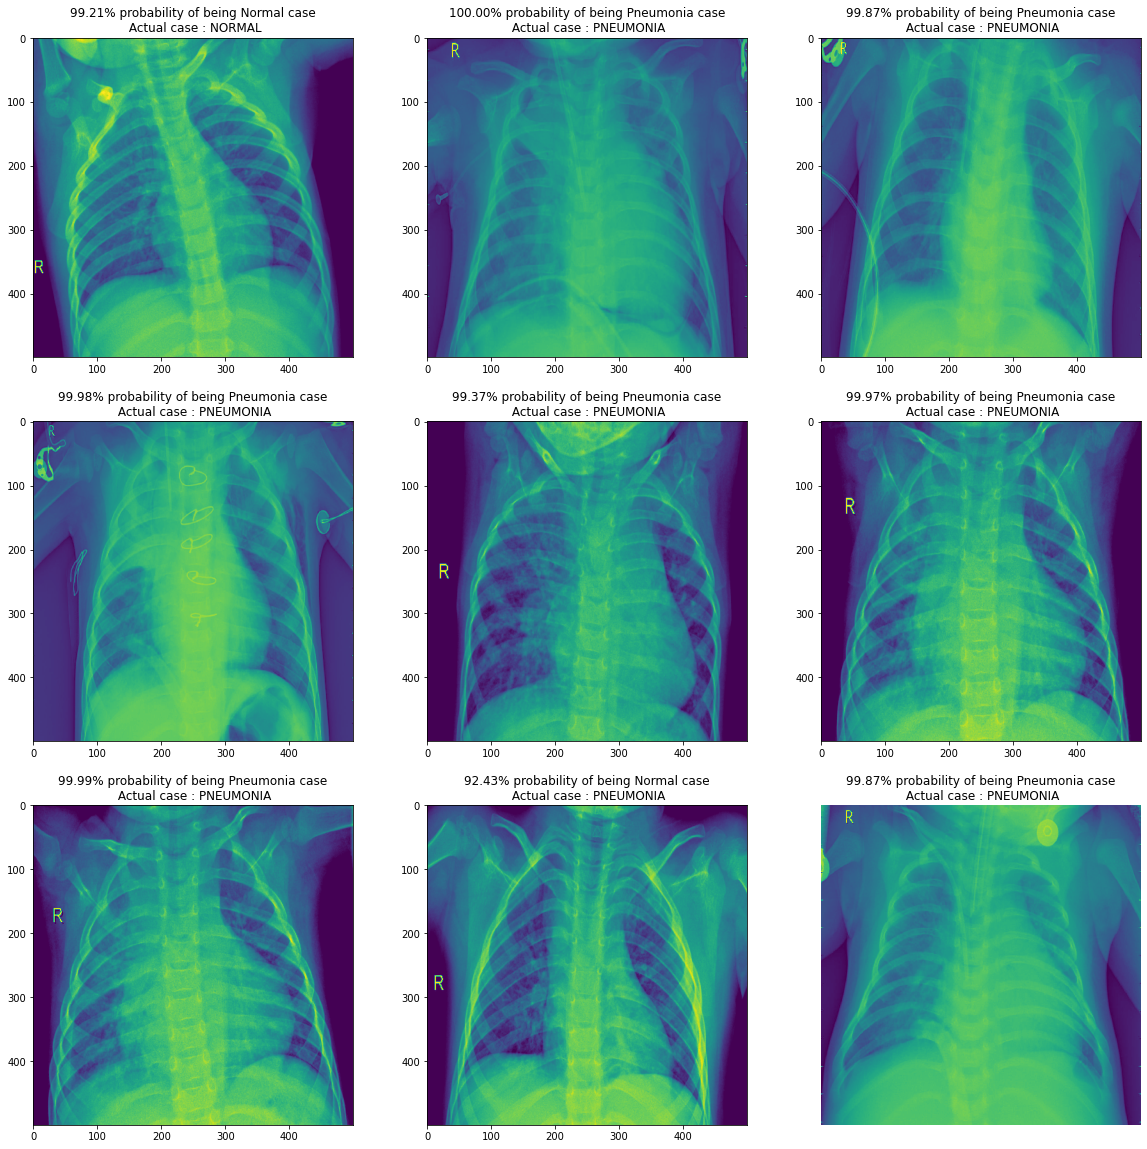

### Testing the model on a completely new data

In this step, out of curiosity, I am testing the model on a completely new data, found online
not originating from the given dataset in the assingment, in order to do a final test of the model.
I know the class labels and I run the prediction on the given data, to determine if the model 
will gives us the right prediction. The model correclty assigned the class labels to the new data with
high confidence. The results are visualized on 2 figures.

In [ ]:
# =============================================================================
# New data test - 2 samples
# =============================================================================

# Testing with my own Chest X-Ray
n_path = '/Users/dtrzc/Library/CloudStorage/OneDrive-Personal/0_MASTERS/3_Deep_Learning/exam/n.png'
p_path = '/Users/dtrzc/Library/CloudStorage/OneDrive-Personal/0_MASTERS/3_Deep_Learning/exam/p.png'

from tensorflow.keras.preprocessing import image
n_img = image.load_img(n_path, target_size=(img_height, img_width),color_mode='grayscale')
p_img = image.load_img(p_path, target_size=(img_height, img_width),color_mode='grayscale')

# Preprocessing normal image
pp_n_img = image.img_to_array(n_img)
pp_n_img = pp_n_img/255
pp_n_img = np.expand_dims(pp_n_img, axis=0)

# Preprocessing pneumonia image
pp_p_img = image.img_to_array(p_img)
pp_p_img = pp_p_img/255
pp_p_img = np.expand_dims(pp_p_img, axis=0)

#predict
n_preds= model.predict(pp_n_img)
p_preds= model.predict(pp_p_img)

#%% Plotting prediction on Normal sample
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if n_preds>= 0.5: 
    out = ('I am {:.2%} percent confident that this is a Pneumonia case'.format(n_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confident that this is a Normal case'.format(1-n_preds[0][0]))
plt.title("NORMAL Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_n_img))
#%% Plotting prediction on a Pneumonia sample
plt.figure(figsize=(6,6))
plt.axis('off')
if p_preds>= 0.5: 
    out = ('I am {:.2%} percent confident that this is a Pneumonia case'.format(p_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confident that this is a Normal case'.format(1-p_preds[0][0]))
plt.title("Pneumonia Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_p_img))

plt.show()



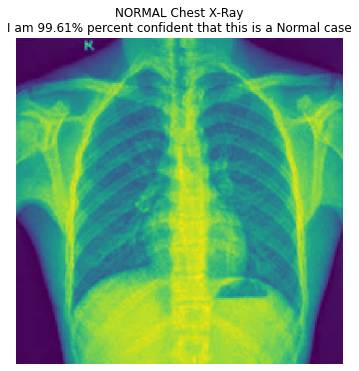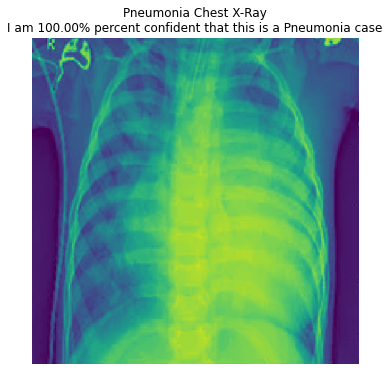

After testing several model and finidng the best performing model on the training/validation/test split data
I fit this model to the entire dataset (100% as training) in a separate code file and save it as
full_dataset_model.h5 in order to test it on an unseen test data.

# Summary

My model scored 92% accuracy on the new test dataset, scoring 2nd place in the class, being surpassed by less than 0.5 percent point and being way more complex than the architecture proposed by my model.